Make sure the tf version is 2.5.0-dev20201111 or later (for model saving)

In [1]:
#!pip install tf-nightly -qqq --progress-bar off
import tensorflow as tf
print(tf.__version__)
#assert tf.__version__== '2.5.0-dev20201111','bad version'

2.4.0


In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
!nvidia-smi -L

GPU 0: Tesla P4 (UUID: GPU-c4d94fb3-889e-3bb3-ef24-51ce0bb2ae93)


In [5]:
from datetime import datetime;now = datetime.now;t00 = now()
print(t00)

2021-01-04 15:25:15.824970


In [6]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.8546183560001737
GPU (s):
0.03527044800011936
GPU speedup over CPU: 80x


In [7]:
from google.colab import drive
drive.mount("/content/drive")
print('done, mounted')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
done, mounted


In [8]:
cd '/content/drive/My Drive/BC-MRI-AE/Colab Notebooks'

/content/drive/My Drive/BC-MRI-AE/Colab Notebooks


In [9]:
%matplotlib inline

import os
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm

#from contrastive_vae.celeb_utils import get_celeb_vae
#from contrastive_vae.celeb_utils import get_celeb_cvae

import pandas as pd
from sklearn.metrics import silhouette_score

from mri_utils import get_MRI_CVAE_3D,get_MRI_CCVAE_3D

print(now()-t00)

0:00:04.930998


In [10]:
cd ../

/content/drive/My Drive/BC-MRI-AE


SHAPE THE DATA

In [11]:
arr = np.load('./Data/ABIDE-Anat-64iso.npz')
ABIDE_data = arr['data']
ABIDE_subs = arr['subs']
nsubs = ABIDE_data.shape[0]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

[(1022,), (1022, 64, 64, 64)]

In [12]:
aa = np.array([ABIDE_data[s,:,:,:].sum() for s in range(ABIDE_data.shape[0])])<5000
ABIDE_data = ABIDE_data[~aa,:,:,:]
ABIDE_subs = ABIDE_subs[~aa]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

[(982,), (982, 64, 64, 64)]

In [13]:
df = pd.read_csv('./CSVs/ABIDE-legend.csv',header=0)
df = df.iloc[np.array([df['BIDS_ID'].values[s] in ABIDE_subs for s in range(len(df))])]
df.reset_index(inplace=True)

assert len(df)==len(ABIDE_subs),'dif lenghts'
assert all([df['BIDS_ID'][s]==ABIDE_subs[s] for s in range(len(df))]),'mismatch between df and goodsubs'

df.head(5)

index  BIDS_ID  ... Medication Name Off stimulants at EPI scan?
0      0  sub-001  ...             NaN                         NaN
1      1  sub-002  ...             NaN                         NaN
2      2  sub-003  ...             NaN                         NaN
3      3  sub-004  ...             NaN                         NaN
4      4  sub-005  ...             NaN                         NaN

[5 rows x 79 columns]

In [14]:
TD_subs = ABIDE_data[np.array(df['Subject Type']=='CONTROL'),:,:,:]
DX_subs = ABIDE_data[np.array(df['Subject Type']=='PATIENT'),:,:,:]

print(TD_subs.shape)
print(DX_subs.shape)

(500, 64, 64, 64)
(456, 64, 64, 64)


In [15]:
dxArr = np.ones(len(df))
dxArr[np.array(df['Subject Type']=='PATIENT')]=2

# TRAIN THE VAE

In [16]:
train_vae = False

In [17]:
if train_vae:
  from scipy.spatial.distance import pdist
  from scipy.spatial.distance import squareform

  def plot_recon_vae():
      plt.figure(figsize=(5,5));
      plt.subplot(2,2,1)
      plt.imshow(DX_batch[0,:,:,40]);plt.xticks([]);plt.yticks([]);plt.title('input');
      plt.subplot(2,2,2)
      plt.imshow(cvae.predict([DX_batch,TD_batch])[0][0,:,:,40,0]);plt.xticks([]);plt.yticks([]);plt.title('reconstruction');

      plt.subplot(2,2,3)
      plt.imshow(TD_batch[0,32,:,:]);plt.xticks([]);plt.yticks([]);
      plt.subplot(2,2,4)
      plt.imshow(cvae.predict([DX_batch,TD_batch])[1][0,32,:,:,0]);plt.xticks([]);plt.yticks([]);

In [18]:
if train_vae:
  encoder, decoder, vae = get_MRI_CVAE_3D(input_shape=(64, 64, 64, 1), latent_dim=32, batch_size=5, disentangle=False, gamma=1)
  #vae.load_weights('../tf_outputs/3D_VAE_Weights/Nov23_VAE'

In [19]:
if train_vae:
  plt.imshow(decoder.predict(np.random.rand(4,32))[0,:,:,40,0])

In [20]:
#vae.train_on_batch(TD_subs[0:5,:,:,:])

In [21]:
# t0 = now()
# print(f'started: {now()}')
# loss = list()
# for i in range(1):
#     e0 = now()
#     #hist = vae.fit([DX_subs,TD_subs[0:456,:,:,:]],epochs=1)

#     loss.append(hist.history['loss']);loss = loss[0:min((50,len(loss)))]

#     cvae.save_weights('../tf_outputs/3D_CCVAE_Weights/Nov23')
#     print(f"epoch time: {now()-e0}, elapsed time: {now()-t0}")
#     if np.mod(i,25)==0:
#         #plot_state_ccvae(latent_dim)
#         plot_recon_vae()
#         plt.show()
#         plt.plot(loss);plt.title('loss')
#         plt.show()
# print(f'done in: {now()-t0}')

In [22]:
#plot_state_cvae()

# TRAIN THE CONTRASTIVE VAE

In [23]:
train_cvae = True

In [24]:
if train_cvae:
  import tensorflow as tf
  import numpy as np
  import matplotlib.pyplot as plt
  from scipy.special import expit
  from sklearn.metrics import silhouette_score
  from tensorflow.keras.layers import *
  from tensorflow.keras import backend as K
  from tensorflow.keras.models import Model
  from tensorflow.keras.losses import mse
  import os
  import pandas as pd
  from glob import glob
  #import helper


  def sampling(args):
      """Reparameterization trick by sampling fr an isotropic unit Gaussian.
      # Arguments:
          args (tensor): mean and log of variance of Q(z|X)
      # Returns:
          z (tensor): sampled latent vector
      """

      z_mean, z_log_var = args
      batch = K.shape(z_mean)[0]
      dim = K.int_shape(z_mean)[1]
      # by default, random_normal has mean=0 and std=1.0
      epsilon = K.random_normal(shape=(batch, dim))
      return z_mean + K.exp(0.5 * z_log_var) * epsilon


  def get_MRI_CVAE_3D(input_shape=(64,64,64,1), latent_dim=2, batch_size = 32, disentangle=False, gamma=1):
      #TODO: add discriminator loss, see if there is improvement. Perhaps try on shapes dataset if it's easier...

      image_size, _, _, channels = input_shape
      kernel_size = 3
      filters = 16
      intermediate_dim = 128
      epochs = 10
      nlayers = 2
      
      # VAE model = encoder + decoder
      # build encoder model
      inputs = Input(shape=input_shape, name='encoder_input')
      x = inputs
      for i in range(nlayers):
          filters *= 2
          x = Conv3D(filters=filters,
                    kernel_size=kernel_size,
                    activation='relu',
                    strides=2,
                    padding='same')(x)

      # shape info needed to build decoder model
      shape = K.int_shape(x)

      # generate latent vector Q(z|X)
      x = Flatten()(x)
      x = Dense(intermediate_dim, activation='relu')(x)
      z_mean = Dense(latent_dim, name='z_mean')(x)
      z_log_var = Dense(latent_dim, name='z_log_var')(x)

      # use reparameterization trick to push the sampling out as input
      # note that "output_shape" isn't necessary with the TensorFlow backend
      z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

      # instantiate encoder model
      encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

      # build decoder model
      latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
      x = Dense(intermediate_dim, activation='relu')(latent_inputs)
      x = Dense(shape[1] * shape[2] * shape[3] * shape[4], activation='relu')(x)
      x = Reshape((shape[1], shape[2], shape[3],shape[4]))(x)

      for i in range(nlayers):
          x = Conv3DTranspose(filters=filters,
                              kernel_size=kernel_size,
                              activation='relu',
                              strides=2,
                              padding='same')(x)
          filters //= 2

      outputs = Conv3DTranspose(filters=1,
                                kernel_size=kernel_size,
                                activation='sigmoid',
                                padding='same',
                                name='decoder_output')(x)

      # instantiate decoder model
      decoder = Model(latent_inputs, outputs, name='decoder')

      #     decoder.summary()

      # instantiate VAE model
      outputs = decoder(encoder(inputs)[2])
      vae = Model(inputs, outputs, name='vae')

      if disentangle:
          discriminator = Dense(1, activation='sigmoid')

          z1 = Lambda(lambda x: x[:int(batch_size/2),:int(latent_dim/2)])(z)
          z2 = Lambda(lambda x: x[int(batch_size/2):,:int(latent_dim/2)])(z)
          s1 = Lambda(lambda x: x[:int(batch_size/2),int(latent_dim/2):])(z)
          s2 = Lambda(lambda x: x[int(batch_size/2):,int(latent_dim/2):])(z)
          q_bar = tf.keras.layers.concatenate(
              [tf.keras.layers.concatenate([s1, z2], axis=1),
              tf.keras.layers.concatenate([s2, z1], axis=1)],
              axis=0)
          q = tf.keras.layers.concatenate(
              [tf.keras.layers.concatenate([s1, z1], axis=1),
              tf.keras.layers.concatenate([s2, z2], axis=1)],
              axis=0)
          q_bar_score = discriminator(q_bar)
          q_score = discriminator(q)        
          tc_loss = K.log(q_score / (1 - q_score)) 

          discriminator_loss = - K.log(q_score) - K.log(1 - q_bar_score)

      reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
      reconstruction_loss *= image_size * image_size


      kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
      kl_loss = K.sum(kl_loss, axis=-1)
      kl_loss *= -0.5
      if disentangle:
          vae_loss = K.mean(reconstruction_loss) + K.mean(kl_loss) + gamma * K.mean(tc_loss) + K.mean(discriminator_loss)
      else:
          vae_loss = K.mean(reconstruction_loss) + K.mean(kl_loss)

      vae.add_loss(vae_loss)
      vae.compile(optimizer='rmsprop')
      if disentangle:
          vae.metrics_tensors = [reconstruction_loss, kl_loss, tc_loss, discriminator_loss]
      #     vae.summary()
      return encoder, decoder, vae



  ####################################################################################################
  ####################################################################################################
  ####################################################################################################
  ####################################################################################################
  ####################################################################################################


  def get_MRI_CCVAE_3D(input_shape=(64,64,64,1), latent_dim=2, beta=1, disentangle=False, gamma=1, bias=True,batch_size = 64):
      
      image_size, _, _, channels = input_shape
      kernel_size = 3
      filters = 16
      intermediate_dim = 128
      epochs = 10
      nlayers = 2

      # build encoder model
      tg_inputs = Input(shape=input_shape, name='tg_inputs')
      bg_inputs = Input(shape=input_shape, name='bg_inputs')

      z_conv1 = Conv3D(filters=filters*2,
                kernel_size=kernel_size,
                activation='relu',
                strides=2,
                use_bias=bias,
                padding='same')
      
      z_conv2 = Conv3D(filters=filters*4,
                kernel_size=kernel_size,
                activation='relu',
                strides=2,
                use_bias=bias,
                padding='same')


      # generate latent vector Q(z|X)
      z_h_layer = Dense(intermediate_dim, activation='relu', use_bias=bias)
      z_mean_layer = Dense(latent_dim, name='z_mean', use_bias=bias)
      z_log_var_layer = Dense(latent_dim, name='z_log_var', use_bias=bias)
      z_layer = Lambda(sampling, output_shape=(latent_dim,), name='z')
      
      def z_encoder_func(inputs):
          z_h = inputs
          z_h = z_conv1(z_h)
          z_h = z_conv2(z_h)
          # shape info needed to build decoder model
          shape = K.int_shape(z_h)
          z_h = Flatten()(z_h)
          z_h = z_h_layer(z_h)
          z_mean =  z_mean_layer(z_h)
          z_log_var =  z_log_var_layer(z_h)
          z = z_layer([z_mean, z_log_var])
          return z_mean, z_log_var, z, shape

      tg_z_mean, tg_z_log_var, tg_z, shape_z = z_encoder_func(tg_inputs)
      
      
      s_conv1 = Conv3D(filters=filters*2,
                kernel_size=kernel_size,
                activation='relu',
                strides=2,
                use_bias=bias,
                padding='same')
      
      s_conv2 = Conv3D(filters=filters*4,
                kernel_size=kernel_size,
                activation='relu',
                strides=2,
                use_bias=bias,
                padding='same')


      # generate latent vector Q(z|X)
      s_h_layer = Dense(intermediate_dim, activation='relu', use_bias=bias)
      s_mean_layer = Dense(latent_dim, name='s_mean', use_bias=bias)
      s_log_var_layer = Dense(latent_dim, name='s_log_var', use_bias=bias)
      s_layer = Lambda(sampling, output_shape=(latent_dim,), name='s')
      
      def s_encoder_func(inputs):
          s_h = inputs
          s_h = s_conv1(s_h)
          s_h = s_conv2(s_h)
          # shape info needed to build decoder model
          shape = K.int_shape(s_h)
          s_h = Flatten()(s_h)
          s_h = s_h_layer(s_h)
          s_mean =  s_mean_layer(s_h)
          s_log_var =  s_log_var_layer(s_h)
          s = s_layer([s_mean, s_log_var])
          return s_mean, s_log_var, s, shape

      tg_s_mean, tg_s_log_var, tg_s, shape_s = s_encoder_func(tg_inputs)
      bg_s_mean, bg_s_log_var, bg_s, _ = s_encoder_func(bg_inputs) 
      

      # instantiate encoder models
      z_encoder = tf.keras.models.Model(tg_inputs, [tg_z_mean, tg_z_log_var, tg_z], name='z_encoder')
      s_encoder = tf.keras.models.Model(tg_inputs, [tg_s_mean, tg_s_log_var, tg_s], name='s_encoder')

  #    print("shape z")
  #    print(shape_z)
      
      # build decoder model
      latent_inputs = Input(shape=(2*latent_dim,), name='z_sampling')
      x = Dense(intermediate_dim, activation='relu', use_bias=bias)(latent_inputs)
      x = Dense(shape_z[1] * shape_z[2] * shape_z[3] * shape_z[4], activation='relu', use_bias=bias)(x)
      x = Reshape((shape_z[1], shape_z[2], shape_z[3],shape_z[4]))(x)
      
  #     x = Dense(shape_z[1] * shape_z[2] * shape_z[3], activation='relu', use_bias=bias)(x)
  #     x = Reshape((shape_z[1], shape_z[2], shape_z[3]))(x)

      for i in range(nlayers):
          x = Conv3DTranspose(filters=filters,
                              kernel_size=kernel_size,
                              activation='relu',
                              strides=2,
                              use_bias=bias,
                              padding='same')(x)
          filters //= 2

      outputs = Conv3DTranspose(filters=1,
                                kernel_size=kernel_size,
                                activation='sigmoid',
                                padding='same',
                                use_bias=bias,
                                name='decoder_output')(x)

      # instantiate decoder model
      cvae_decoder = Model(latent_inputs, outputs, name='decoder')
      # decoder.summary()

      def zeros_like(x):
          return tf.zeros_like(x)

      tg_outputs = cvae_decoder(tf.keras.layers.concatenate([tg_z, tg_s], -1))
      zeros = tf.keras.layers.Lambda(zeros_like)(tg_z)
      bg_outputs = cvae_decoder(tf.keras.layers.concatenate([zeros, bg_s], -1))
      fg_outputs = cvae_decoder(tf.keras.layers.concatenate([tg_z, zeros], -1))

      # instantiate VAE model
      cvae = tf.keras.models.Model(inputs=[tg_inputs, bg_inputs], 
                                  outputs=[tg_outputs, bg_outputs], 
                                  name='contrastive_vae')

      cvae_fg = tf.keras.models.Model(inputs=tg_inputs, 
                                      outputs=fg_outputs, 
                                      name='contrastive_vae_fg')
      
      if disentangle:
          discriminator = Dense(1, activation='sigmoid')
          
          z1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_z)
          z2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_z)
          s1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_s)
          s2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_s)
          
          q_bar = tf.keras.layers.concatenate(
              [tf.keras.layers.concatenate([s1, z2], axis=1),
              tf.keras.layers.concatenate([s2, z1], axis=1)],
              axis=0)
          q = tf.keras.layers.concatenate(
              [tf.keras.layers.concatenate([s1, z1], axis=1),
              tf.keras.layers.concatenate([s2, z2], axis=1)],
              axis=0)
          
          q_bar_score = discriminator(q_bar)
          q_score = discriminator(q)        
          tc_loss = K.log(q_score / (1 - q_score)) 
          
          discriminator_loss = - K.log(q_score) - K.log(1 - q_bar_score)
      else:
          tc_loss = 0
          discriminator_loss = 0
      
      
      reconstruction_loss = tf.keras.losses.mse(K.flatten(tg_inputs), K.flatten(tg_outputs))
      reconstruction_loss += tf.keras.losses.mse(K.flatten(bg_inputs), K.flatten(bg_outputs))
      reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2] * input_shape[3]


      kl_loss = 1 + tg_z_log_var - tf.keras.backend.square(tg_z_mean) - tf.keras.backend.exp(tg_z_log_var)
      kl_loss += 1 + tg_s_log_var - tf.keras.backend.square(tg_s_mean) - tf.keras.backend.exp(tg_s_log_var)
      kl_loss += 1 + bg_s_log_var - tf.keras.backend.square(bg_s_mean) - tf.keras.backend.exp(bg_s_log_var)
      kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
      kl_loss *= -0.5

      cvae_loss = tf.keras.backend.mean(reconstruction_loss + beta*kl_loss + gamma * tc_loss + discriminator_loss)
      cvae.add_loss(cvae_loss)
      cvae.compile(optimizer='rmsprop')
      
      return cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder

In [34]:
if train_cvae:
  latent_dim = 2
  cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D(latent_dim=latent_dim,beta=1, disentangle=True, gamma=1, bias=True)
  #cvae.load_weights('../tf_outputs/3D_CCVAE_Weights/Nov23')

In [35]:
batch_size = 64
DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:]
TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:]

In [36]:
def net_query():
  i = 0
  n = 50
  v_sl = s_encoder.predict(ABIDE_data[0:n,:,:,:])[i]#[0,:]
  v_bg = z_encoder.predict(ABIDE_data[0:n,:,:,:])[i]#[0,:]
  v = np.hstack((v_sl,v_bg))
  latent_vec = v;
  out = cvae_decoder.predict(latent_vec)

  im = out[:,:,:,:,0]
  im1 = ABIDE_data[0:n,:,:,:]
  ss = ((im-im1)**2).sum()

  return im[0,32,:,:],im1[0,32,:,:],ss

def net_plot(im,im1):
  plt.subplot(1,2,1);
  plt.imshow(im1);
  plt.subplot(1,2,2);
  plt.imshow(im);


%matplotlib inline
from IPython import display
import time
def plot_trainProgress(loss,im,im1):

  display.clear_output(wait=True)
  display.display(plt.gcf())
  #time.sleep(1.0)

  plt.figure(figsize=np.array((7,5)) )

  plt.subplot(2,2,1)
  plt.imshow(im1);plt.xticks([]);plt.yticks([])
  plt.title('image')

  plt.subplot(2,2,3)
  plt.imshow(im);plt.xticks([]);plt.yticks([])
  plt.title('reconstruction')

  plt.subplot(2,2,2)
  plt.plot(loss);plt.title('overall loss')

  plt.subplot(2,2,4)
  plt.plot(loss);plt.title('loss: last 100 iteration')

  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.15, hspace=.45)

  plt.show()

In [37]:
# Make tqdm work for colab
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

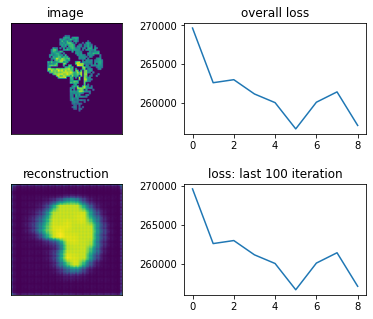

  2%|▏         | 10/500 [00:21<17:45,  2.17s/it]

UnknownError: ignored

In [40]:
loss = list()
for i in tqdm(range(500)):
  DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:]
  TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:]
  cvae.train_on_batch([DX_batch,TD_batch])
  im,im1,ss = net_query();
  loss.append(ss)
  if np.mod(i,2)==0:
    plot_trainProgress(loss,im,im1)

In [ ]:

# # import time
# # import pylab as pl

# # for i in range(10):
# #     pl.plot(pl.randn(100))
# #     display.clear_output(wait=True)
# #     display.display(pl.gcf())
# #     time.sleep(1.0)

# xs = np.arange(10)
# ys = np.zeros(10)
# for i in range(10):
#   ys[i] = i
#   plt.plot(xs,ys,'k.',markersize=25)
#   plt.ylim(1,10);
#   #display.clear_output(wait=True)
#   #display.display(plt.gcf())
#   #plt.clf()
#   #time.sleep(1.0)